In [22]:
# !!!!!!!!!!!!!!!!!!!!downloaded sam with pip install, look in the reademe for more info!!!!!!!!!!!!!!!!!

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml
from PIL import Image
from skimage import measure
from scipy import ndimage

In [2]:
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device='cuda')

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

In [3]:
import cv2
import numpy as np

def resize_image(img, new_width):
    # Get the original image size
    height, width, _ = img.shape

    # Calculate the aspect ratio
    ratio = new_width / width

    # Calculate the new height with the aspect ratio
    new_height = int(height * ratio)

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Return the resized image as a numpy array
    return np.array(resized_img)

In [29]:
# interessante bilder: 'mini_testdatensatz/train/picture_9.png' --> problem mit pixelfehler


image = cv2.imread('mini_testdatensatz/train/picture_767.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = resize_image(image, 192)

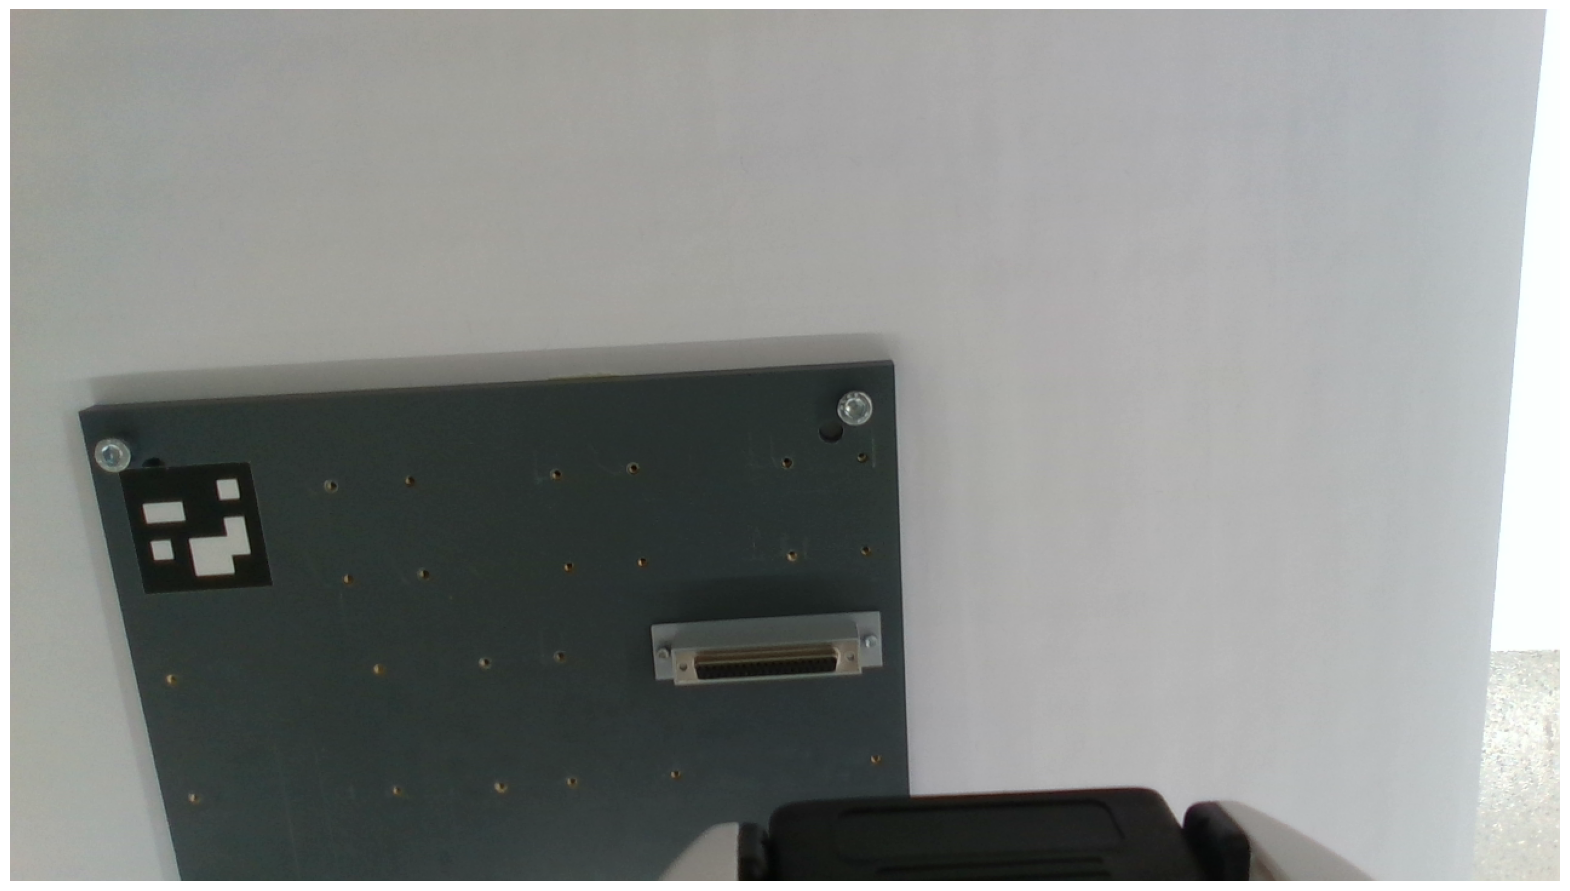

In [30]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [31]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [32]:
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [33]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    colors = []
    with open('colors.yaml', 'r') as f:
        colors = yaml.safe_load(f)
    color_index = 0
    for ann in sorted_anns:
        m = ann['segmentation'] # m is a binary mask
        print("Area" , ann['area']) # Area is the number of true pixels in the mask
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = colors[color_index]
        color_index = (color_index + 1) % len(colors) # cycle through colors if more than len(colors) annotations
        print(color_mask)
        for i in range(3):
            img[:,:,i] = color_mask[i] / 255.0 # normalize RGB values to range [0,1]
        #ax.imshow(np.dstack((img, m*0.35)))
        ax.imshow(np.dstack((img,0.8*m)))

Area 595152
[0, 255, 255]
Area 277413
[255, 0, 0]
Area 250375
[0, 255, 0]
Area 33587
[0, 0, 255]
Area 30759
[255, 255, 0]
Area 26698
[255, 0, 255]
Area 18570
[0, 0, 0]
Area 12164
[255, 128, 0]
Area 11074
[255, 255, 255]
Area 9603
[128, 0, 255]
Area 9364
[128, 255, 0]
Area 3841
[0, 255, 128]
Area 3757
[0, 128, 255]
Area 3010
[255, 128, 128]
Area 2909
[128, 255, 128]
Area 2682
[128, 128, 255]
Area 2149
[192, 192, 192]
Area 1926
[128, 128, 128]
Area 1607
[64, 64, 64]
Area 1169
[255, 0, 128]
Area 857
[0, 255, 255]
Area 703
[255, 0, 0]
Area 675
[0, 255, 0]
Area 572
[0, 0, 255]
Area 303
[255, 255, 0]
Area 115
[255, 0, 255]
Area 104
[0, 0, 0]
Area 99
[255, 128, 0]
Area 94
[255, 255, 255]
Area 88
[128, 0, 255]
Area 70
[128, 255, 0]
Area 59
[0, 255, 128]


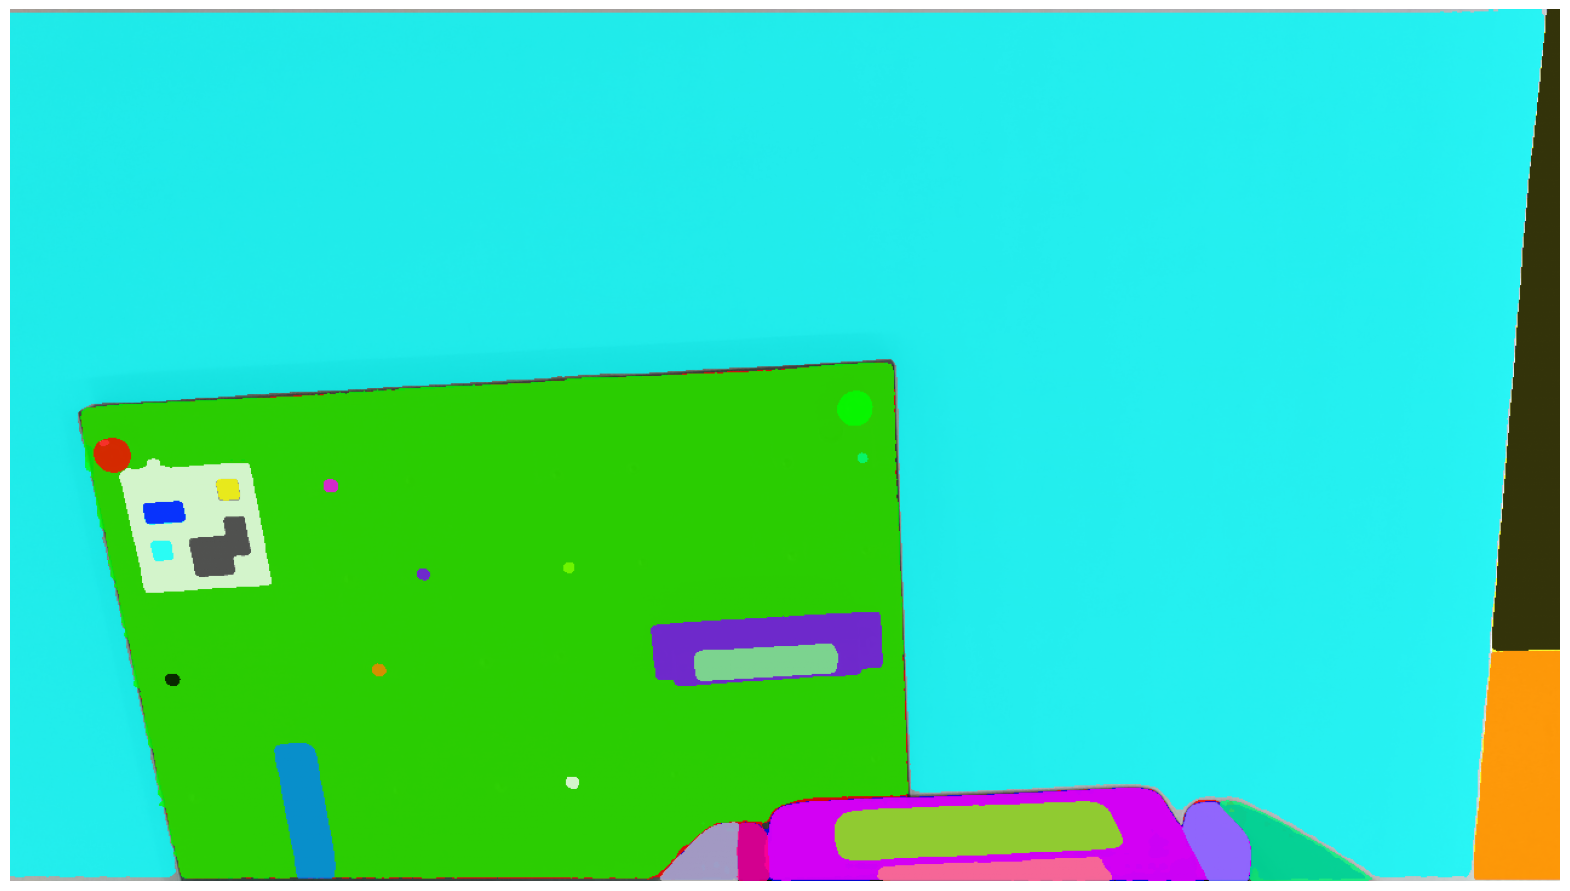

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [35]:
def is_mask_inside(large_mask, small_mask):
    indices = np.where(small_mask)
    return np.all(large_mask[indices])

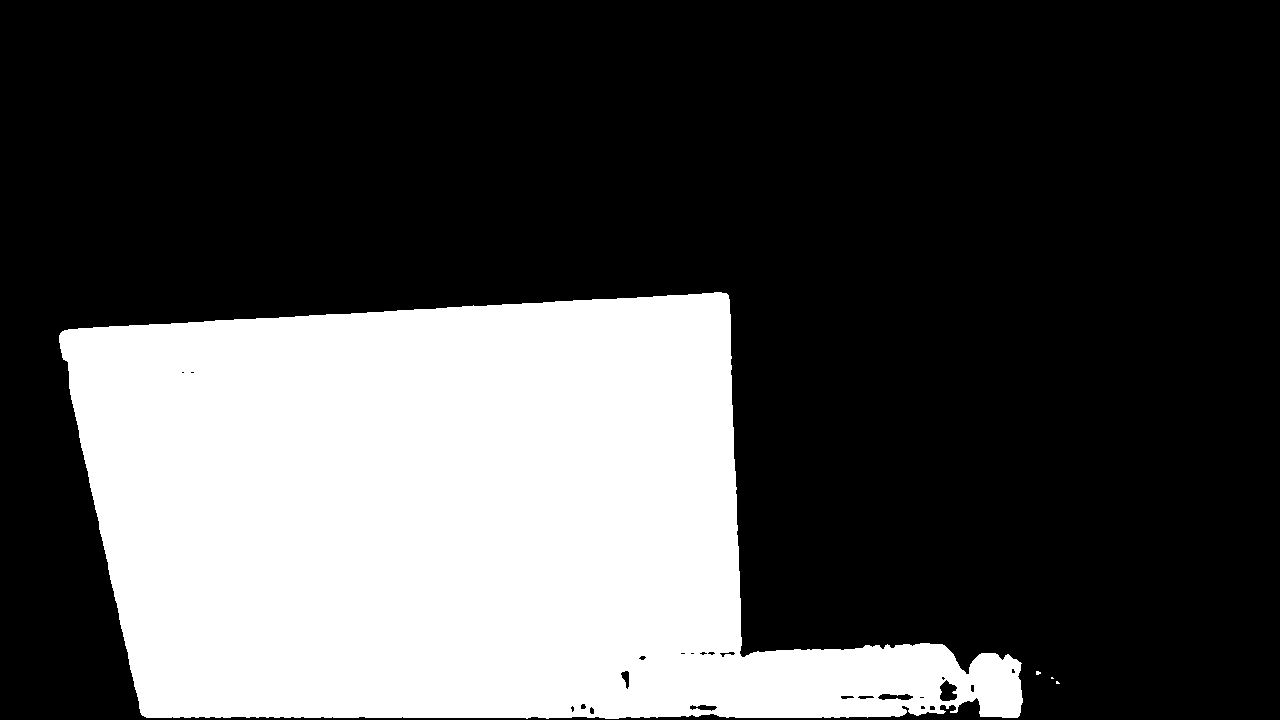

In [36]:
sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
intersection = []
for i in range(4): # 4, because the board should always be in the first 4 masks
    maybe_board_mask = sorted_masks[i]['segmentation']
    nb_intersection = 0
    for j in range(len(sorted_masks)-1):
        if is_mask_inside(maybe_board_mask, sorted_masks[j]['segmentation']):
            nb_intersection += 1
    intersection.append(nb_intersection)
board_mask = sorted_masks[np.argmax(intersection)]['segmentation']


board_image = Image.fromarray(board_mask.astype('uint8') * 255, mode='L')
display(board_image)


In [37]:
inside_masks = []
min_overlap_percentage = 85

for i in range(2, len(sorted_masks)):
    small_mask = sorted_masks[i]['segmentation']
    num_small_mask_true = np.sum(small_mask)
    required_overlap = int(num_small_mask_true * min_overlap_percentage / 100)
    indices = np.where(small_mask)
    num_overlapping_true = np.sum(board_mask[indices])

    if num_overlapping_true >= required_overlap:
        inside_masks.append(small_mask)

    # if is_mask_inside(board_mask, small_mask):
    #     inside_masks.append(small_mask)

In [38]:
def count_true_values(mask):
    return np.sum(mask)

In [39]:
def find_biggest_contiguous_area(array):
    labels,_ = ndimage.label(array)
    counts = np.bincount(labels.flatten())
    max_label = np.argmax(counts[1:]) + 1
    region = (labels == max_label)
    
    return region

In [44]:
inside_masks_sorted = sorted(inside_masks, key=count_true_values, reverse=True)

plug_mask_1 = inside_masks_sorted[0]
plug_mask_1 = find_biggest_contiguous_area(plug_mask_1)
plug_mask_2 = inside_masks_sorted[1]
plug_mask_2 = find_biggest_contiguous_area(plug_mask_2)
plug_mask_3 = inside_masks_sorted[3]
plug_mask_3 = find_biggest_contiguous_area(plug_mask_3)

contours_1 = measure.find_contours(plug_mask_1, 0.5)
contours_2 = measure.find_contours(plug_mask_2, 0.5)
contours_3 = measure.find_contours(plug_mask_3, 0.5)

x_max_1 = np.max([np.max(contour[:, 1]) for contour in contours_1])
y_max_1 = np.max([np.max(contour[:, 0]) for contour in contours_1])
ratio_1 = x_max_1 / y_max_1

x_max_2 = np.max([np.max(contour[:, 1]) for contour in contours_2])
y_max_2 = np.max([np.max(contour[:, 0]) for contour in contours_2])
ratio_2 = x_max_2 / y_max_2

x_max_3 = np.max([np.max(contour[:, 1]) for contour in contours_3])
y_max_3 = np.max([np.max(contour[:, 0]) for contour in contours_3])
ratio_3 = x_max_3 / y_max_3

true_1 = count_true_values(plug_mask_1)
true_2 = count_true_values(plug_mask_2)
true_3 = count_true_values(plug_mask_3)


1.0334494773519163 1.4248956884561892 1.2900626678603402


1.0334494773519163


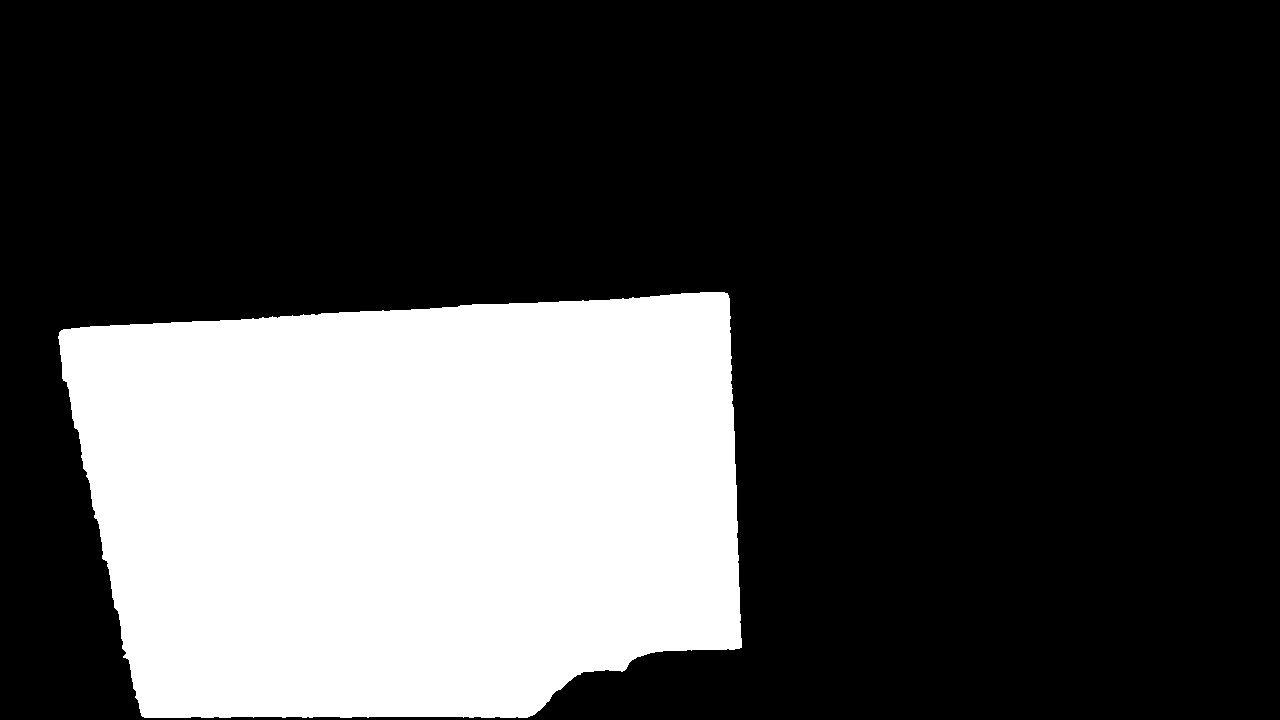

In [48]:
plug_image = Image.fromarray(plug_mask_1.astype('uint8') * 255, mode='L')
print(ratio_1)
display(plug_image)


1.4248956884561892


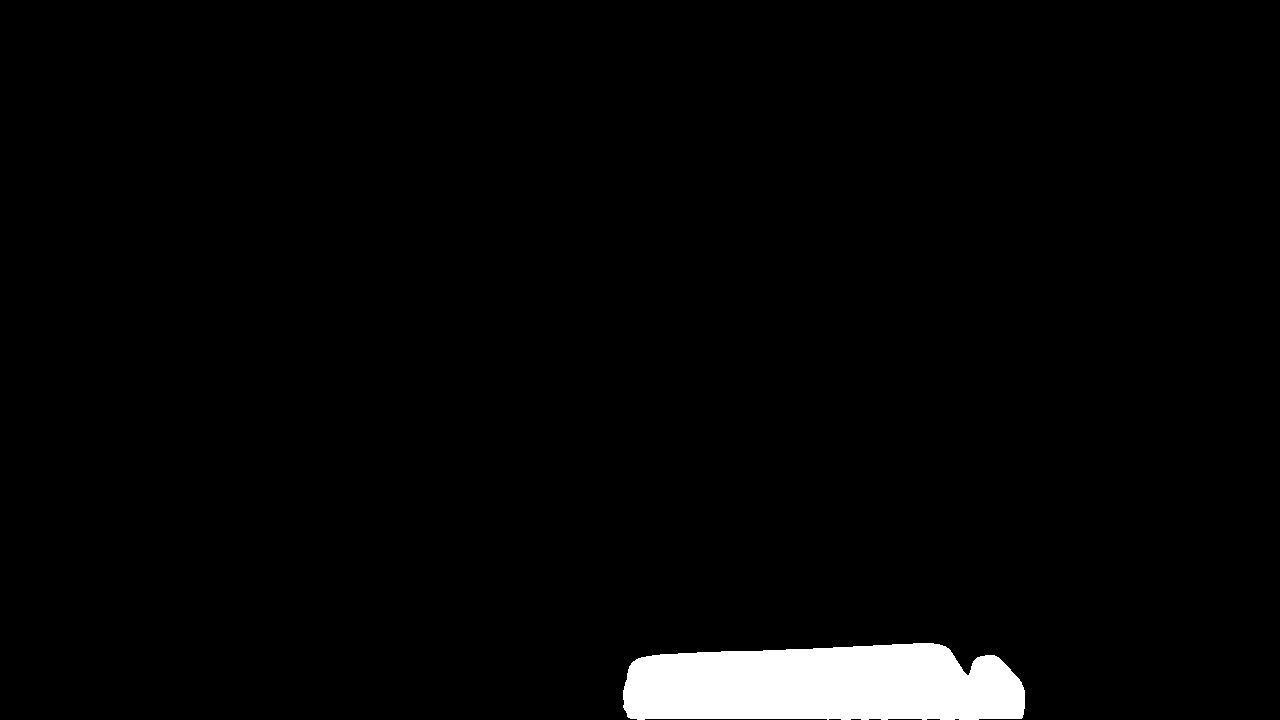

In [49]:
plug_image = Image.fromarray(plug_mask_2.astype('uint8') * 255, mode='L')
print(ratio_2)
display(plug_image)

1.2900626678603402


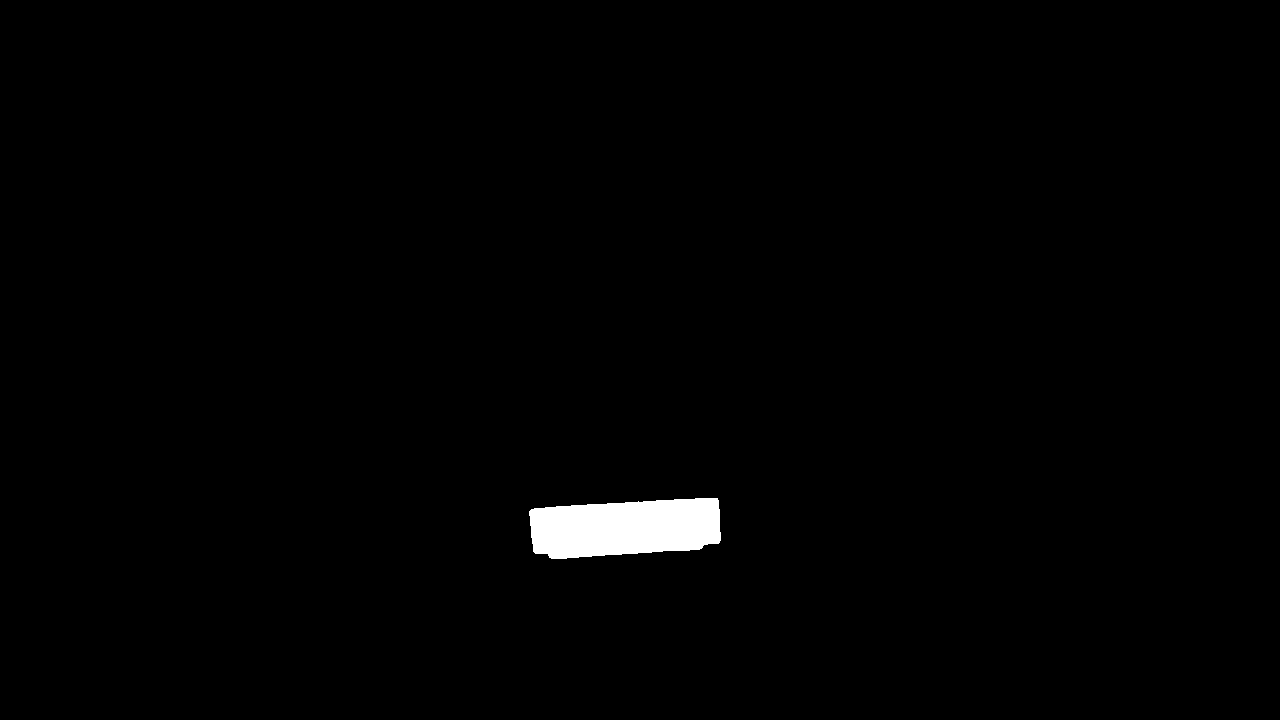

In [50]:
plug_image = Image.fromarray(plug_mask_3.astype('uint8') * 255, mode='L')
print(ratio_3)
display(plug_image)

In [18]:
import numpy as np
from scipy import ndimage

def find_biggest_contiguous_area(array):
    # Label contiguous regions
    labels, num_labels = ndimage.label(array)
    
    # Count the number of pixels in each region
    counts = np.bincount(labels.flatten())
    
    # Find the label with the maximum count
    max_label = np.argmax(counts[1:]) + 1
    
    # Extract the corresponding region
    region = (labels == max_label)
    
    return region

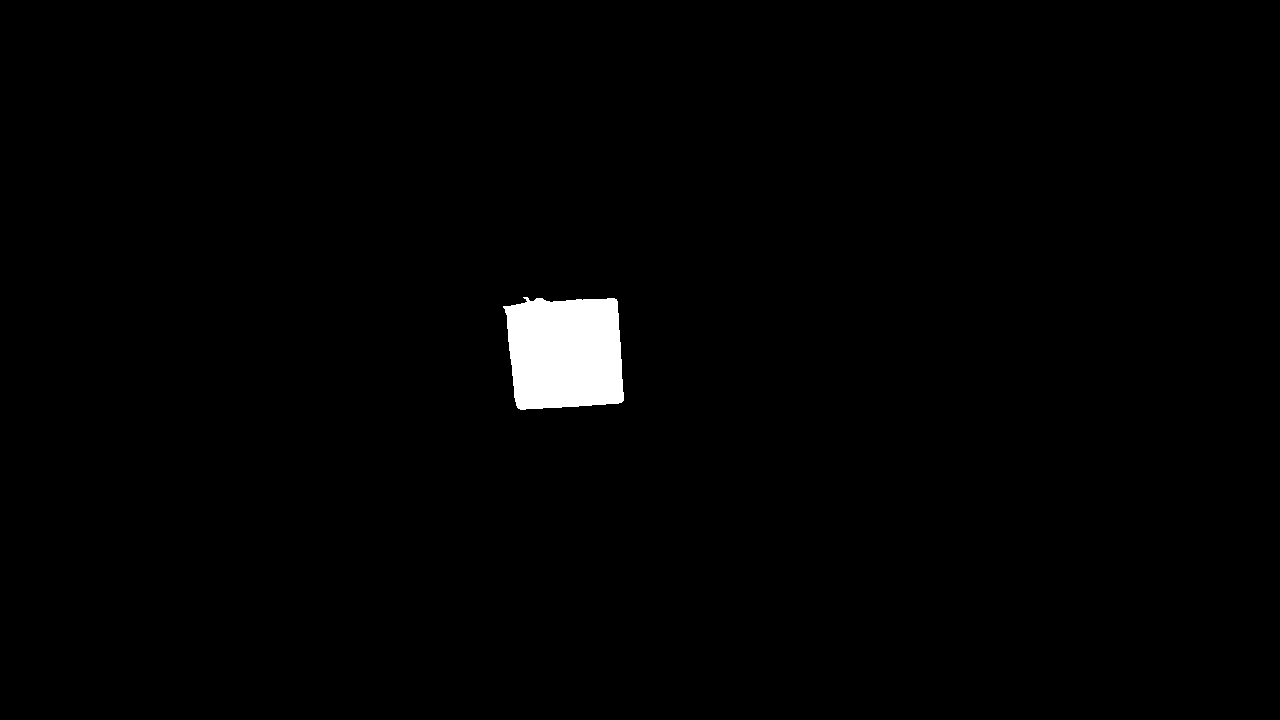

In [19]:
plug_mask_2 = inside_masks_sorted[1]
plug_mask_2 = find_biggest_contiguous_area(plug_mask_2)

plug_image = Image.fromarray(plug_mask_2.astype('uint8') * 255, mode='L')
display(plug_image)